# Deep learning with ICCD images of plasma plumes generated during pulsed laser deposition for growth kinetics prediction - ICCD Model

#### Sumner B. Harris

This notebook is designed to provide a functional example of using (2+1)D CNNs to extract deep features from ICCD image sequences for growth kinetics prediction during pulsed laser deposition (PLD).

Start by importing the required packages:

In [1]:
# Import some basics
import os
import datetime

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Import our custom modules
import ICCDutils
import models

# Import Torch stuff
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

## Define the dataset class

In [2]:
class PLDdataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform, target_params, augment=True):
        self.df = dataframe
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get growth parameters
        params = torch.tensor([self.df.loc[idx,'P'],self.df.loc[idx,'T'],self.df.loc[idx,'E1'],self.df.loc[idx,'E2']],dtype=torch.float32)
        
        # get targets
        if target_params == 'anomaly':
            target = torch.tensor([self.df.loc[idx,'P'],self.df.loc[idx,'E1'],self.df.loc[idx,'E2']],dtype=torch.float32)
        if target_params == 'growth':
            target = torch.tensor([self.df.loc[idx,'s0'],self.df.loc[idx,'s1'],self.df.loc[idx,'J']],dtype=torch.float32)

        # get ICCD image sequence
        image1 = torch.tensor(self.df.loc[idx,'ICCD'],dtype=torch.float32)

        if self.augment:
            image1 = self.transform(image1)      
            # add measurement noise to parameters for augmentation
            params[0] = params[0] + torch.randn(1)*2*np.sqrt(params[0]*0.00125) # account for 2 sigma, 0.25% baratron accuracy
            params[1] = params[1] + torch.randn(1)*2*np.sqrt(params[1]*0.0075)# account for 2 sigma, 1.5% temperature
            params[2] = params[2] + torch.randn(1)*2*np.sqrt(params[2]*0.0075)# account for 2 sigma, 1.5% laser stability accuracy
            params[3] = params[3] + torch.randn(1)*2*np.sqrt(params[3]*0.0075)# account for 2 sigma, 1.5% laser stability accuracy

        return image1, params, target

## Make a helper function to load the data and split into training and validation sets

In [3]:
def load_data(datafile, target_params, normalize_PTE1E2, train_percent=70):
    # Create a transform for the ICCD images
    transform = transforms.RandomAffine(180,
                                    translate=(0.1,0.1),
                                    shear=10,
                                    scale=(0.8,1.2))
    
    # load the full data from the json file
    df = ICCDutils.load_df(datafile, normalize_PTE1E2=normalize_PTE1E2)
    
    train_number = int(len(df)*train_percent/100)
    val_number = len(df)-train_number
    print('Total number of samples: {}'.format(len(df)))
    print('Number of training samples: {}\nNumber of validation samples: {}'.format(train_number, val_number))
    
    # instantiate the PLDdataset class
    dataset = PLDdataset(df, transform, target_params)
    
    # set a seed for reproducibility
    generator = torch.Generator().manual_seed(42)
    
    # randomly split the data into training and validation sets
    train_data, val_data = random_split(dataset,[train_number,val_number],generator=generator)
    
    return train_data, val_data

# Define the training function

In [4]:
def model_train_best(config, target_params, normalize_PTE1E2, chk_name):
    train_loss_list = []
    test_loss_list = []
    r2_list = []
    print("I'M TRAINING, I'M TRAINING!!")
    model = models.ICCDNet(l1=config['l1'],l2=config['l2'])
    
    device = 'cpu'
    if torch.cuda.is_available():
        print('Using GPU.')
        device = "cuda:0"    
        if torch.cuda.device_count() > 1:
            print('Using multiple GPUs.')
            model = nn.DataParallel(model)
    model.to(device)
    loss_fn = nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=config['lr'],amsgrad=True,weight_decay=config['weight_decay'])
    
    BATCH_SIZE = 88
    train_data, val_data = load_data(datafile, target_params, normalize_PTE1E2, train_percent=70)
    
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

    #print('Total image feature params:',sum(p.numel() for p in model.ICCD_features_.parameters()))
    #print('Total model params:',sum(p.numel() for p in model.parameters()))

    loss_values = []
    val_loss_values = []
    best_R2 = 0.0
    n_epochs=2000
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        for id_batch, (image1,params,target) in enumerate(train_loader):
            image1=image1.to(device)
            score = target.to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(image1)
            loss = loss_fn(y_pred, score)

            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        loss_values.append(loss_train/len(train_loader))
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch,
                                                          loss_train / len(train_loader)))
        
        train_pred, train_actuals = y_pred.cpu(), score.cpu()
        size = len(val_loader.dataset)
        num_batches = len(val_loader)
        test_loss = 0.0
        train_loss_list.append(loss_train)
        
        for (image1,params,target) in val_loader:
            with torch.no_grad():
                image1=image1.to(device)
                score = target.to(device)
                pred = model(image1)
                test_loss += loss_fn(pred, score).item()
                pr2 = pearsonr(score[:,0].cpu(), pred[:,0].cpu())[0]**2
                e1r2 = pearsonr(score[:,1].cpu(), pred[:,1].cpu())[0]**2
                e2r2 = pearsonr(score[:,2].cpu(), pred[:,2].cpu())[0]**2
                meanR2 = np.array([pr2,e1r2,e2r2]).mean()
                print('R2 values {:.4f}, {:.4f}, {:.4f}; mean R2={:.4f}'.format(pr2, e1r2, e2r2, meanR2))
                r2_list.append([pr2, e1r2, e2r2,meanR2])
                
        if meanR2>best_R2:
            print('New best, saving checkpoint...')
            best_R2 = meanR2
            best_val_predictions, best_val_actuals = pred.cpu().detach(), score.cpu().detach()
            best_train_predictions, best_train_actuals = train_pred.cpu().detach(), train_actuals.cpu().detach()
            
            torch.save(model.state_dict(), 'Model Checkpoints/ICCDNet_l1-{:.4f}_l2-{:.4f}_lr-{:.4f}_L2-{:.4f}.model'.format(config['l1'],config['l2'], config['lr'],config['weight_decay']))
        test_loss /= num_batches
        test_loss_list.append(test_loss)
        val_loss_values.append(test_loss)
        print(f"Test Error: Avg loss: {test_loss:>8f} \n")
        #train.report({"mean_R2": meanR2})
        
    return best_R2, train_loss_list, test_loss_list, r2_list, best_train_predictions, best_train_actuals, best_val_predictions, best_val_actuals

# Set up the configuration and train the model

In [6]:
config = {
        'l1': 64,
        'l2': 32,
        'lr': 0.0014129147018238114,
        'weight_decay': 0.0005312227896860003
}

datafile = 'PLD data.json'
target_params = 'growth'
normalize_PTE1E2 = True
chk_name = 'ICCD_growth'

BATCH_SIZE = 88

best_R2, train_loss_list, test_loss_list, r2_list, best_train_predictions, best_train_actuals, best_val_predictions, best_val_actuals = model_train_best(config, target_params, normalize_PTE1E2, chk_name)

I'M TRAINING, I'M TRAINING!!
Using GPU.
Total number of samples: 127
Number of training samples: 88
Number of validation samples: 39
2023-11-16 14:34:29.474696 Epoch 1, Training loss 24.53727149963379
R2 values 0.0054, 0.0006, 0.1651; mean R2=0.0570
New best, saving checkpoint...
Test Error: Avg loss: 25.543713 

2023-11-16 14:34:29.954091 Epoch 2, Training loss 25.799026489257812
R2 values 0.1922, 0.0077, 0.2441; mean R2=0.1480
New best, saving checkpoint...
Test Error: Avg loss: 19.938524 

2023-11-16 14:34:30.430821 Epoch 3, Training loss 18.487014770507812
R2 values 0.4223, 0.0706, 0.4019; mean R2=0.2982
New best, saving checkpoint...
Test Error: Avg loss: 12.903482 

2023-11-16 14:34:30.902210 Epoch 4, Training loss 14.120024681091309
R2 values 0.2282, 0.0150, 0.3408; mean R2=0.1947
Test Error: Avg loss: 12.016865 

2023-11-16 14:34:31.362020 Epoch 5, Training loss 12.082829475402832
R2 values 0.0927, 0.0927, 0.3502; mean R2=0.1786
Test Error: Avg loss: 13.792127 

2023-11-16 14:3

2023-11-16 14:34:52.889832 Epoch 52, Training loss 4.707892894744873
R2 values 0.5526, 0.6014, 0.6793; mean R2=0.6111
Test Error: Avg loss: 5.323634 

2023-11-16 14:34:53.342605 Epoch 53, Training loss 5.056488037109375
R2 values 0.6048, 0.5174, 0.7051; mean R2=0.6091
Test Error: Avg loss: 6.437091 

2023-11-16 14:34:53.789736 Epoch 54, Training loss 5.190018177032471
R2 values 0.4913, 0.5792, 0.6552; mean R2=0.5752
Test Error: Avg loss: 5.379442 

2023-11-16 14:34:54.255540 Epoch 55, Training loss 4.121145248413086
R2 values 0.5170, 0.5716, 0.6576; mean R2=0.5821
Test Error: Avg loss: 5.378606 

2023-11-16 14:34:54.711539 Epoch 56, Training loss 4.808037281036377
R2 values 0.4457, 0.5880, 0.6138; mean R2=0.5491
Test Error: Avg loss: 5.509020 

2023-11-16 14:34:55.159918 Epoch 57, Training loss 4.962784290313721
R2 values 0.4781, 0.6541, 0.6694; mean R2=0.6005
Test Error: Avg loss: 5.005607 

2023-11-16 14:34:55.608752 Epoch 58, Training loss 4.371823787689209
R2 values 0.5837, 0.5805,

2023-11-16 14:35:17.720894 Epoch 106, Training loss 3.4634013175964355
R2 values 0.6232, 0.6083, 0.7097; mean R2=0.6471
Test Error: Avg loss: 4.822134 

2023-11-16 14:35:18.183556 Epoch 107, Training loss 3.578185558319092
R2 values 0.5823, 0.6276, 0.7316; mean R2=0.6472
Test Error: Avg loss: 4.778805 

2023-11-16 14:35:18.636551 Epoch 108, Training loss 3.334916591644287
R2 values 0.6150, 0.5265, 0.6584; mean R2=0.6000
Test Error: Avg loss: 6.182672 

2023-11-16 14:35:19.092239 Epoch 109, Training loss 2.9531567096710205
R2 values 0.5901, 0.5799, 0.7587; mean R2=0.6429
Test Error: Avg loss: 5.140586 

2023-11-16 14:35:19.549733 Epoch 110, Training loss 3.141249418258667
R2 values 0.5594, 0.6519, 0.6988; mean R2=0.6367
Test Error: Avg loss: 4.861032 

2023-11-16 14:35:20.014350 Epoch 111, Training loss 2.851578712463379
R2 values 0.5989, 0.6300, 0.6687; mean R2=0.6326
Test Error: Avg loss: 5.059756 

2023-11-16 14:35:20.476437 Epoch 112, Training loss 3.4257845878601074
R2 values 0.500

2023-11-16 14:35:42.549416 Epoch 160, Training loss 3.076115131378174
R2 values 0.5231, 0.6374, 0.7184; mean R2=0.6263
Test Error: Avg loss: 5.142659 

2023-11-16 14:35:43.002974 Epoch 161, Training loss 2.7197377681732178
R2 values 0.4878, 0.6608, 0.6475; mean R2=0.5987
Test Error: Avg loss: 5.482102 

2023-11-16 14:35:43.462409 Epoch 162, Training loss 2.6856460571289062
R2 values 0.6126, 0.6909, 0.7885; mean R2=0.6973
Test Error: Avg loss: 4.378589 

2023-11-16 14:35:43.918411 Epoch 163, Training loss 2.4690566062927246
R2 values 0.6690, 0.6140, 0.7093; mean R2=0.6641
Test Error: Avg loss: 5.351824 

2023-11-16 14:35:44.376591 Epoch 164, Training loss 2.549457550048828
R2 values 0.5326, 0.6833, 0.7197; mean R2=0.6452
Test Error: Avg loss: 4.296327 

2023-11-16 14:35:44.830012 Epoch 165, Training loss 2.680361270904541
R2 values 0.5134, 0.6189, 0.7113; mean R2=0.6145
Test Error: Avg loss: 5.043131 

2023-11-16 14:35:45.285944 Epoch 166, Training loss 2.486499786376953
R2 values 0.633

2023-11-16 14:36:07.352330 Epoch 214, Training loss 2.377929925918579
R2 values 0.6226, 0.6956, 0.7013; mean R2=0.6731
Test Error: Avg loss: 4.286462 

2023-11-16 14:36:07.806699 Epoch 215, Training loss 1.6842286586761475
R2 values 0.7040, 0.7793, 0.7580; mean R2=0.7471
Test Error: Avg loss: 3.190099 

2023-11-16 14:36:08.258292 Epoch 216, Training loss 2.3435895442962646
R2 values 0.7891, 0.6628, 0.6770; mean R2=0.7096
Test Error: Avg loss: 5.685455 

2023-11-16 14:36:08.716503 Epoch 217, Training loss 2.0416958332061768
R2 values 0.6567, 0.7043, 0.7639; mean R2=0.7083
Test Error: Avg loss: 4.890884 

2023-11-16 14:36:09.169872 Epoch 218, Training loss 2.1976327896118164
R2 values 0.6350, 0.6832, 0.7286; mean R2=0.6823
Test Error: Avg loss: 4.075079 

2023-11-16 14:36:09.626740 Epoch 219, Training loss 2.4221298694610596
R2 values 0.6205, 0.7201, 0.7345; mean R2=0.6917
Test Error: Avg loss: 3.747794 

2023-11-16 14:36:10.082871 Epoch 220, Training loss 1.947987675666809
R2 values 0.7

2023-11-16 14:36:32.088349 Epoch 268, Training loss 2.3871257305145264
R2 values 0.6296, 0.6859, 0.7447; mean R2=0.6867
Test Error: Avg loss: 4.337462 

2023-11-16 14:36:32.547011 Epoch 269, Training loss 1.5701148509979248
R2 values 0.7237, 0.6900, 0.7933; mean R2=0.7357
Test Error: Avg loss: 3.860396 

2023-11-16 14:36:32.998922 Epoch 270, Training loss 1.961262583732605
R2 values 0.6117, 0.6717, 0.7563; mean R2=0.6799
Test Error: Avg loss: 4.235144 

2023-11-16 14:36:33.456803 Epoch 271, Training loss 1.8856498003005981
R2 values 0.5177, 0.6669, 0.7778; mean R2=0.6541
Test Error: Avg loss: 4.904174 

2023-11-16 14:36:33.910161 Epoch 272, Training loss 1.6602681875228882
R2 values 0.6706, 0.7260, 0.7768; mean R2=0.7245
Test Error: Avg loss: 4.190851 

2023-11-16 14:36:34.369218 Epoch 273, Training loss 1.5124627351760864
R2 values 0.4417, 0.6973, 0.7579; mean R2=0.6323
Test Error: Avg loss: 4.679912 

2023-11-16 14:36:34.824228 Epoch 274, Training loss 1.5142642259597778
R2 values 0.

2023-11-16 14:36:56.736699 Epoch 322, Training loss 1.247758388519287
R2 values 0.7594, 0.6860, 0.8006; mean R2=0.7487
Test Error: Avg loss: 4.134257 

2023-11-16 14:36:57.196146 Epoch 323, Training loss 1.1996643543243408
R2 values 0.5982, 0.6920, 0.8032; mean R2=0.6978
Test Error: Avg loss: 4.518678 

2023-11-16 14:36:57.644489 Epoch 324, Training loss 1.0463522672653198
R2 values 0.6710, 0.6463, 0.7370; mean R2=0.6848
Test Error: Avg loss: 5.301177 

2023-11-16 14:36:58.096545 Epoch 325, Training loss 1.145906925201416
R2 values 0.6347, 0.7018, 0.7943; mean R2=0.7103
Test Error: Avg loss: 4.336196 

2023-11-16 14:36:58.549955 Epoch 326, Training loss 1.0327731370925903
R2 values 0.6778, 0.7340, 0.8369; mean R2=0.7496
Test Error: Avg loss: 3.985788 

2023-11-16 14:36:59.009646 Epoch 327, Training loss 1.168016791343689
R2 values 0.6184, 0.7115, 0.8166; mean R2=0.7155
Test Error: Avg loss: 4.270050 

2023-11-16 14:36:59.468141 Epoch 328, Training loss 1.1586099863052368
R2 values 0.59

2023-11-16 14:37:21.447761 Epoch 376, Training loss 1.0235589742660522
R2 values 0.6420, 0.6849, 0.8445; mean R2=0.7238
Test Error: Avg loss: 4.110632 

2023-11-16 14:37:21.903032 Epoch 377, Training loss 1.1556726694107056
R2 values 0.6609, 0.6936, 0.8244; mean R2=0.7263
Test Error: Avg loss: 3.969793 

2023-11-16 14:37:22.361387 Epoch 378, Training loss 0.9995214343070984
R2 values 0.6721, 0.7108, 0.8146; mean R2=0.7325
Test Error: Avg loss: 4.280199 

2023-11-16 14:37:22.819245 Epoch 379, Training loss 0.8467592597007751
R2 values 0.6742, 0.6968, 0.7927; mean R2=0.7212
Test Error: Avg loss: 4.428951 

2023-11-16 14:37:23.273025 Epoch 380, Training loss 0.9593024849891663
R2 values 0.6032, 0.6999, 0.8166; mean R2=0.7066
Test Error: Avg loss: 4.085944 

2023-11-16 14:37:23.727031 Epoch 381, Training loss 1.157763957977295
R2 values 0.5740, 0.7341, 0.8061; mean R2=0.7047
Test Error: Avg loss: 3.915639 

2023-11-16 14:37:24.182015 Epoch 382, Training loss 0.8404725193977356
R2 values 0.

2023-11-16 14:37:46.061502 Epoch 430, Training loss 0.8990563154220581
R2 values 0.6773, 0.7463, 0.8124; mean R2=0.7453
Test Error: Avg loss: 3.493030 

2023-11-16 14:37:46.507484 Epoch 431, Training loss 0.742861807346344
R2 values 0.6201, 0.7366, 0.8206; mean R2=0.7258
Test Error: Avg loss: 3.818078 

2023-11-16 14:37:46.955923 Epoch 432, Training loss 0.8463724255561829
R2 values 0.6946, 0.7017, 0.7928; mean R2=0.7297
Test Error: Avg loss: 3.856523 

2023-11-16 14:37:47.401484 Epoch 433, Training loss 0.8328666090965271
R2 values 0.6553, 0.7195, 0.7815; mean R2=0.7188
Test Error: Avg loss: 4.094745 

2023-11-16 14:37:47.847201 Epoch 434, Training loss 0.7887980341911316
R2 values 0.6872, 0.7403, 0.8276; mean R2=0.7517
Test Error: Avg loss: 3.667182 

2023-11-16 14:37:48.289744 Epoch 435, Training loss 0.8041540384292603
R2 values 0.6226, 0.7465, 0.8011; mean R2=0.7234
Test Error: Avg loss: 3.734188 

2023-11-16 14:37:48.734870 Epoch 436, Training loss 0.7808380126953125
R2 values 0.

2023-11-16 14:38:10.178394 Epoch 484, Training loss 0.5258244872093201
R2 values 0.6441, 0.6783, 0.8092; mean R2=0.7105
Test Error: Avg loss: 4.594643 

2023-11-16 14:38:10.619492 Epoch 485, Training loss 0.5892543196678162
R2 values 0.6554, 0.7337, 0.8184; mean R2=0.7358
Test Error: Avg loss: 3.827061 

2023-11-16 14:38:11.064428 Epoch 486, Training loss 0.5971841812133789
R2 values 0.6194, 0.7242, 0.8176; mean R2=0.7204
Test Error: Avg loss: 3.660640 

2023-11-16 14:38:11.511821 Epoch 487, Training loss 0.714841365814209
R2 values 0.6332, 0.7417, 0.8477; mean R2=0.7408
Test Error: Avg loss: 3.648377 

2023-11-16 14:38:11.959614 Epoch 488, Training loss 0.574741005897522
R2 values 0.7059, 0.6901, 0.8316; mean R2=0.7425
Test Error: Avg loss: 4.534192 

2023-11-16 14:38:12.404200 Epoch 489, Training loss 0.6805266737937927
R2 values 0.6777, 0.7332, 0.8402; mean R2=0.7503
Test Error: Avg loss: 3.680131 

2023-11-16 14:38:12.853699 Epoch 490, Training loss 0.534112274646759
R2 values 0.61

2023-11-16 14:38:34.186658 Epoch 538, Training loss 0.5087181925773621
R2 values 0.6969, 0.7682, 0.8139; mean R2=0.7597
Test Error: Avg loss: 3.597440 

2023-11-16 14:38:34.629960 Epoch 539, Training loss 0.4940812289714813
R2 values 0.5036, 0.7011, 0.7867; mean R2=0.6638
Test Error: Avg loss: 4.411220 

2023-11-16 14:38:35.075604 Epoch 540, Training loss 0.4610791802406311
R2 values 0.6024, 0.7019, 0.7932; mean R2=0.6992
Test Error: Avg loss: 3.806137 

2023-11-16 14:38:35.515513 Epoch 541, Training loss 0.6653264164924622
R2 values 0.6391, 0.6974, 0.8071; mean R2=0.7145
Test Error: Avg loss: 4.031194 

2023-11-16 14:38:35.959572 Epoch 542, Training loss 0.42882856726646423
R2 values 0.5752, 0.7061, 0.7857; mean R2=0.6890
Test Error: Avg loss: 4.456661 

2023-11-16 14:38:36.403443 Epoch 543, Training loss 0.4693126380443573
R2 values 0.5239, 0.6957, 0.7850; mean R2=0.6682
Test Error: Avg loss: 4.460623 

2023-11-16 14:38:36.845356 Epoch 544, Training loss 0.48966923356056213
R2 values

2023-11-16 14:38:58.207248 Epoch 592, Training loss 0.5067582726478577
R2 values 0.5961, 0.7245, 0.8385; mean R2=0.7197
Test Error: Avg loss: 3.572142 

2023-11-16 14:38:58.651640 Epoch 593, Training loss 0.42575526237487793
R2 values 0.5797, 0.6684, 0.7900; mean R2=0.6794
Test Error: Avg loss: 4.433668 

2023-11-16 14:38:59.095914 Epoch 594, Training loss 0.45465001463890076
R2 values 0.6288, 0.7385, 0.7909; mean R2=0.7194
Test Error: Avg loss: 4.042085 

2023-11-16 14:38:59.547668 Epoch 595, Training loss 0.4454851448535919
R2 values 0.6330, 0.7340, 0.7906; mean R2=0.7192
Test Error: Avg loss: 4.132555 

2023-11-16 14:38:59.991969 Epoch 596, Training loss 0.4339393377304077
R2 values 0.6316, 0.7097, 0.8284; mean R2=0.7232
Test Error: Avg loss: 3.734386 

2023-11-16 14:39:00.434773 Epoch 597, Training loss 0.5226839780807495
R2 values 0.6451, 0.7207, 0.8174; mean R2=0.7277
Test Error: Avg loss: 4.126318 

2023-11-16 14:39:00.880414 Epoch 598, Training loss 0.34321242570877075
R2 value

2023-11-16 14:39:22.248704 Epoch 646, Training loss 0.3694303333759308
R2 values 0.5825, 0.7332, 0.8113; mean R2=0.7090
Test Error: Avg loss: 3.773718 

2023-11-16 14:39:22.691002 Epoch 647, Training loss 0.43362128734588623
R2 values 0.7241, 0.7694, 0.8187; mean R2=0.7707
Test Error: Avg loss: 3.632876 

2023-11-16 14:39:23.133048 Epoch 648, Training loss 0.5223883986473083
R2 values 0.6716, 0.7827, 0.7909; mean R2=0.7484
Test Error: Avg loss: 3.599255 

2023-11-16 14:39:23.581682 Epoch 649, Training loss 0.5025897026062012
R2 values 0.7195, 0.8091, 0.8096; mean R2=0.7794
Test Error: Avg loss: 2.840725 

2023-11-16 14:39:24.028601 Epoch 650, Training loss 0.4687623679637909
R2 values 0.6202, 0.7550, 0.8561; mean R2=0.7437
Test Error: Avg loss: 3.407043 

2023-11-16 14:39:24.478639 Epoch 651, Training loss 0.4066075086593628
R2 values 0.5400, 0.7123, 0.8067; mean R2=0.6863
Test Error: Avg loss: 4.023140 

2023-11-16 14:39:24.925422 Epoch 652, Training loss 0.5432215332984924
R2 values 

2023-11-16 14:39:46.975089 Epoch 700, Training loss 0.4069846272468567
R2 values 0.5820, 0.7142, 0.7856; mean R2=0.6939
Test Error: Avg loss: 4.798848 

2023-11-16 14:39:47.417691 Epoch 701, Training loss 0.5590624213218689
R2 values 0.5932, 0.7210, 0.7906; mean R2=0.7016
Test Error: Avg loss: 4.263995 

2023-11-16 14:39:47.862575 Epoch 702, Training loss 0.4648998975753784
R2 values 0.6687, 0.7457, 0.7920; mean R2=0.7354
Test Error: Avg loss: 3.633744 

2023-11-16 14:39:48.304194 Epoch 703, Training loss 0.5327239036560059
R2 values 0.6747, 0.7277, 0.8194; mean R2=0.7406
Test Error: Avg loss: 3.534796 

2023-11-16 14:39:48.744486 Epoch 704, Training loss 0.4300616383552551
R2 values 0.6188, 0.7194, 0.8016; mean R2=0.7133
Test Error: Avg loss: 4.454569 

2023-11-16 14:39:49.192213 Epoch 705, Training loss 0.47623223066329956
R2 values 0.6959, 0.7226, 0.8153; mean R2=0.7446
Test Error: Avg loss: 4.350863 

2023-11-16 14:39:49.641642 Epoch 706, Training loss 0.37629982829093933
R2 values

2023-11-16 14:40:11.376986 Epoch 754, Training loss 0.42381003499031067
R2 values 0.6998, 0.7390, 0.8148; mean R2=0.7512
Test Error: Avg loss: 3.644969 

2023-11-16 14:40:11.821223 Epoch 755, Training loss 0.3966217041015625
R2 values 0.5535, 0.7654, 0.7975; mean R2=0.7055
Test Error: Avg loss: 3.842753 

2023-11-16 14:40:12.268124 Epoch 756, Training loss 0.36091530323028564
R2 values 0.6694, 0.7220, 0.8095; mean R2=0.7336
Test Error: Avg loss: 3.951170 

2023-11-16 14:40:12.713048 Epoch 757, Training loss 0.2887917757034302
R2 values 0.6021, 0.7196, 0.7977; mean R2=0.7065
Test Error: Avg loss: 4.134454 

2023-11-16 14:40:13.160099 Epoch 758, Training loss 0.2996690273284912
R2 values 0.5867, 0.7471, 0.8399; mean R2=0.7245
Test Error: Avg loss: 3.686915 

2023-11-16 14:40:13.609120 Epoch 759, Training loss 0.36345142126083374
R2 values 0.6787, 0.7214, 0.8348; mean R2=0.7450
Test Error: Avg loss: 3.918180 

2023-11-16 14:40:14.051425 Epoch 760, Training loss 0.3081907629966736
R2 value

2023-11-16 14:40:35.652193 Epoch 808, Training loss 0.31192123889923096
R2 values 0.6413, 0.7711, 0.7615; mean R2=0.7246
Test Error: Avg loss: 3.623647 

2023-11-16 14:40:36.111723 Epoch 809, Training loss 0.3027920126914978
R2 values 0.6257, 0.7217, 0.8118; mean R2=0.7198
Test Error: Avg loss: 4.060636 

2023-11-16 14:40:36.568139 Epoch 810, Training loss 0.24455927312374115
R2 values 0.6110, 0.7423, 0.8573; mean R2=0.7368
Test Error: Avg loss: 3.438879 

2023-11-16 14:40:37.123488 Epoch 811, Training loss 0.3592524528503418
R2 values 0.5915, 0.7159, 0.7767; mean R2=0.6947
Test Error: Avg loss: 4.267304 

2023-11-16 14:40:37.587793 Epoch 812, Training loss 0.28499507904052734
R2 values 0.6789, 0.7496, 0.8088; mean R2=0.7458
Test Error: Avg loss: 3.615145 

2023-11-16 14:40:38.049099 Epoch 813, Training loss 0.26113972067832947
R2 values 0.6195, 0.7510, 0.7954; mean R2=0.7220
Test Error: Avg loss: 3.451115 

2023-11-16 14:40:38.515677 Epoch 814, Training loss 0.31626200675964355
R2 val

2023-11-16 14:41:00.633393 Epoch 862, Training loss 0.33492112159729004
R2 values 0.6940, 0.7381, 0.7945; mean R2=0.7422
Test Error: Avg loss: 3.680044 

2023-11-16 14:41:01.084975 Epoch 863, Training loss 0.2308928519487381
R2 values 0.6271, 0.7468, 0.7817; mean R2=0.7185
Test Error: Avg loss: 3.909111 

2023-11-16 14:41:01.543886 Epoch 864, Training loss 0.27256086468696594
R2 values 0.5231, 0.7351, 0.8230; mean R2=0.6937
Test Error: Avg loss: 4.196813 

2023-11-16 14:41:02.008918 Epoch 865, Training loss 0.2927245497703552
R2 values 0.6293, 0.7263, 0.7709; mean R2=0.7088
Test Error: Avg loss: 3.934553 

2023-11-16 14:41:02.475840 Epoch 866, Training loss 0.3622891306877136
R2 values 0.6804, 0.7056, 0.7799; mean R2=0.7220
Test Error: Avg loss: 4.063021 

2023-11-16 14:41:02.927860 Epoch 867, Training loss 0.2889137268066406
R2 values 0.6941, 0.7524, 0.7811; mean R2=0.7425
Test Error: Avg loss: 3.808682 

2023-11-16 14:41:03.386668 Epoch 868, Training loss 0.41855743527412415
R2 value

2023-11-16 14:41:25.532958 Epoch 916, Training loss 0.23902766406536102
R2 values 0.6524, 0.7635, 0.8136; mean R2=0.7432
Test Error: Avg loss: 3.401819 

2023-11-16 14:41:25.994730 Epoch 917, Training loss 0.23180967569351196
R2 values 0.6850, 0.7628, 0.7365; mean R2=0.7281
Test Error: Avg loss: 3.714293 

2023-11-16 14:41:26.445661 Epoch 918, Training loss 0.22423741221427917
R2 values 0.6219, 0.7684, 0.7629; mean R2=0.7177
Test Error: Avg loss: 3.765397 

2023-11-16 14:41:26.907924 Epoch 919, Training loss 0.1847149282693863
R2 values 0.6095, 0.7584, 0.7953; mean R2=0.7211
Test Error: Avg loss: 3.586059 

2023-11-16 14:41:27.370949 Epoch 920, Training loss 0.2108222246170044
R2 values 0.6046, 0.7282, 0.7609; mean R2=0.6979
Test Error: Avg loss: 4.086109 

2023-11-16 14:41:27.835142 Epoch 921, Training loss 0.1584363430738449
R2 values 0.5747, 0.7044, 0.7763; mean R2=0.6851
Test Error: Avg loss: 4.274827 

2023-11-16 14:41:28.296045 Epoch 922, Training loss 0.2544349431991577
R2 value

2023-11-16 14:41:50.395206 Epoch 970, Training loss 0.24884739518165588
R2 values 0.6884, 0.8018, 0.7792; mean R2=0.7565
Test Error: Avg loss: 3.318447 

2023-11-16 14:41:50.856577 Epoch 971, Training loss 0.27114179730415344
R2 values 0.6535, 0.7633, 0.7941; mean R2=0.7370
Test Error: Avg loss: 3.744562 

2023-11-16 14:41:51.312704 Epoch 972, Training loss 0.21701206266880035
R2 values 0.7374, 0.7597, 0.7783; mean R2=0.7585
Test Error: Avg loss: 3.399380 

2023-11-16 14:41:51.771343 Epoch 973, Training loss 0.21450184285640717
R2 values 0.6712, 0.7590, 0.7654; mean R2=0.7319
Test Error: Avg loss: 3.557884 

2023-11-16 14:41:52.229326 Epoch 974, Training loss 0.2292591780424118
R2 values 0.6289, 0.7386, 0.7751; mean R2=0.7142
Test Error: Avg loss: 3.958637 

2023-11-16 14:41:52.684998 Epoch 975, Training loss 0.33864524960517883
R2 values 0.6766, 0.7564, 0.7800; mean R2=0.7377
Test Error: Avg loss: 3.613834 

2023-11-16 14:41:53.146203 Epoch 976, Training loss 0.22541090846061707
R2 va

2023-11-16 14:42:15.275768 Epoch 1024, Training loss 0.16729329526424408
R2 values 0.6458, 0.7433, 0.7661; mean R2=0.7184
Test Error: Avg loss: 3.774986 

2023-11-16 14:42:15.734866 Epoch 1025, Training loss 0.19996145367622375
R2 values 0.6940, 0.7691, 0.7910; mean R2=0.7514
Test Error: Avg loss: 3.246235 

2023-11-16 14:42:16.203125 Epoch 1026, Training loss 0.22760993242263794
R2 values 0.6260, 0.7501, 0.7871; mean R2=0.7211
Test Error: Avg loss: 3.550629 

2023-11-16 14:42:16.666164 Epoch 1027, Training loss 0.16280131042003632
R2 values 0.6531, 0.7956, 0.7683; mean R2=0.7390
Test Error: Avg loss: 3.229965 

2023-11-16 14:42:17.129400 Epoch 1028, Training loss 0.20022732019424438
R2 values 0.6134, 0.7707, 0.7725; mean R2=0.7189
Test Error: Avg loss: 3.497675 

2023-11-16 14:42:17.593499 Epoch 1029, Training loss 0.17404226958751678
R2 values 0.6303, 0.8046, 0.7613; mean R2=0.7321
Test Error: Avg loss: 3.332602 

2023-11-16 14:42:18.051917 Epoch 1030, Training loss 0.176038831472396

2023-11-16 14:42:39.731520 Epoch 1077, Training loss 0.20392347872257233
R2 values 0.6986, 0.7716, 0.7649; mean R2=0.7451
Test Error: Avg loss: 3.276742 

2023-11-16 14:42:40.193804 Epoch 1078, Training loss 0.2076452225446701
R2 values 0.6079, 0.7704, 0.7870; mean R2=0.7217
Test Error: Avg loss: 3.314467 

2023-11-16 14:42:40.651071 Epoch 1079, Training loss 0.30355703830718994
R2 values 0.6861, 0.7410, 0.8006; mean R2=0.7426
Test Error: Avg loss: 3.974326 

2023-11-16 14:42:41.114281 Epoch 1080, Training loss 0.2135011851787567
R2 values 0.6731, 0.7155, 0.7739; mean R2=0.7208
Test Error: Avg loss: 4.537675 

2023-11-16 14:42:41.583498 Epoch 1081, Training loss 0.25825798511505127
R2 values 0.6372, 0.7311, 0.8132; mean R2=0.7272
Test Error: Avg loss: 3.900261 

2023-11-16 14:42:42.044791 Epoch 1082, Training loss 0.1718052476644516
R2 values 0.5910, 0.7269, 0.7850; mean R2=0.7010
Test Error: Avg loss: 3.798887 

2023-11-16 14:42:42.509907 Epoch 1083, Training loss 0.23278114199638367


2023-11-16 14:43:04.752327 Epoch 1130, Training loss 0.1647479385137558
R2 values 0.6635, 0.7504, 0.7588; mean R2=0.7242
Test Error: Avg loss: 3.583595 

2023-11-16 14:43:05.211213 Epoch 1131, Training loss 0.1921616941690445
R2 values 0.5704, 0.7835, 0.7971; mean R2=0.7170
Test Error: Avg loss: 3.218657 

2023-11-16 14:43:05.668016 Epoch 1132, Training loss 0.17676830291748047
R2 values 0.5183, 0.7328, 0.7775; mean R2=0.6762
Test Error: Avg loss: 4.402325 

2023-11-16 14:43:06.126758 Epoch 1133, Training loss 0.21484346687793732
R2 values 0.5815, 0.7578, 0.7745; mean R2=0.7046
Test Error: Avg loss: 3.676639 

2023-11-16 14:43:06.586357 Epoch 1134, Training loss 0.1467360556125641
R2 values 0.6572, 0.7951, 0.7649; mean R2=0.7391
Test Error: Avg loss: 3.140417 

2023-11-16 14:43:07.043660 Epoch 1135, Training loss 0.1975327581167221
R2 values 0.6137, 0.7791, 0.7534; mean R2=0.7154
Test Error: Avg loss: 3.456767 

2023-11-16 14:43:07.494686 Epoch 1136, Training loss 0.13769535720348358
R

2023-11-16 14:43:29.595904 Epoch 1184, Training loss 0.20177052915096283
R2 values 0.6475, 0.7428, 0.7625; mean R2=0.7176
Test Error: Avg loss: 3.791836 

2023-11-16 14:43:30.061796 Epoch 1185, Training loss 0.17303970456123352
R2 values 0.6091, 0.7550, 0.7643; mean R2=0.7095
Test Error: Avg loss: 3.608541 

2023-11-16 14:43:30.520571 Epoch 1186, Training loss 0.24988031387329102
R2 values 0.5768, 0.7392, 0.7358; mean R2=0.6839
Test Error: Avg loss: 3.948213 

2023-11-16 14:43:30.977230 Epoch 1187, Training loss 0.2125997096300125
R2 values 0.6038, 0.7319, 0.7229; mean R2=0.6862
Test Error: Avg loss: 4.290112 

2023-11-16 14:43:31.439138 Epoch 1188, Training loss 0.2010352611541748
R2 values 0.5389, 0.7372, 0.7470; mean R2=0.6744
Test Error: Avg loss: 3.935728 

2023-11-16 14:43:31.899249 Epoch 1189, Training loss 0.20504917204380035
R2 values 0.5960, 0.7757, 0.7879; mean R2=0.7198
Test Error: Avg loss: 3.358963 

2023-11-16 14:43:32.353163 Epoch 1190, Training loss 0.16807612776756287

2023-11-16 14:43:54.003132 Epoch 1237, Training loss 0.1817687302827835
R2 values 0.6710, 0.7641, 0.7934; mean R2=0.7428
Test Error: Avg loss: 3.487955 

2023-11-16 14:43:54.455879 Epoch 1238, Training loss 0.13264618813991547
R2 values 0.6475, 0.7552, 0.7643; mean R2=0.7223
Test Error: Avg loss: 3.807760 

2023-11-16 14:43:54.914838 Epoch 1239, Training loss 0.13440056145191193
R2 values 0.6570, 0.8056, 0.7454; mean R2=0.7360
Test Error: Avg loss: 3.405454 

2023-11-16 14:43:55.379880 Epoch 1240, Training loss 0.14524753391742706
R2 values 0.6700, 0.7778, 0.7756; mean R2=0.7411
Test Error: Avg loss: 3.302821 

2023-11-16 14:43:55.848492 Epoch 1241, Training loss 0.13393007218837738
R2 values 0.6883, 0.7766, 0.7689; mean R2=0.7446
Test Error: Avg loss: 3.229764 

2023-11-16 14:43:56.312877 Epoch 1242, Training loss 0.19833672046661377
R2 values 0.6341, 0.7788, 0.7991; mean R2=0.7374
Test Error: Avg loss: 3.515095 

2023-11-16 14:43:56.778685 Epoch 1243, Training loss 0.1557157337665558

2023-11-16 14:44:19.084245 Epoch 1290, Training loss 0.13247781991958618
R2 values 0.6730, 0.7741, 0.7678; mean R2=0.7383
Test Error: Avg loss: 3.594902 

2023-11-16 14:44:19.543175 Epoch 1291, Training loss 0.13210849463939667
R2 values 0.6461, 0.7542, 0.7598; mean R2=0.7200
Test Error: Avg loss: 3.861375 

2023-11-16 14:44:20.001625 Epoch 1292, Training loss 0.11636526882648468
R2 values 0.7194, 0.8053, 0.7880; mean R2=0.7709
Test Error: Avg loss: 2.936897 

2023-11-16 14:44:20.460526 Epoch 1293, Training loss 0.13388502597808838
R2 values 0.6015, 0.7581, 0.7927; mean R2=0.7174
Test Error: Avg loss: 3.595689 

2023-11-16 14:44:20.917538 Epoch 1294, Training loss 0.1376761943101883
R2 values 0.7180, 0.7908, 0.7813; mean R2=0.7634
Test Error: Avg loss: 3.221936 

2023-11-16 14:44:21.363917 Epoch 1295, Training loss 0.1090921089053154
R2 values 0.6120, 0.7535, 0.7582; mean R2=0.7079
Test Error: Avg loss: 4.099342 

2023-11-16 14:44:21.829496 Epoch 1296, Training loss 0.14922940731048584

2023-11-16 14:44:43.546791 Epoch 1343, Training loss 0.09380175918340683
R2 values 0.6606, 0.7964, 0.7928; mean R2=0.7499
Test Error: Avg loss: 2.999461 

2023-11-16 14:44:44.004300 Epoch 1344, Training loss 0.11611226201057434
R2 values 0.6825, 0.8063, 0.7800; mean R2=0.7563
Test Error: Avg loss: 3.010268 

2023-11-16 14:44:44.466648 Epoch 1345, Training loss 0.12324205040931702
R2 values 0.7273, 0.7909, 0.8028; mean R2=0.7736
Test Error: Avg loss: 3.078237 

2023-11-16 14:44:44.931397 Epoch 1346, Training loss 0.11735951155424118
R2 values 0.6540, 0.7627, 0.7752; mean R2=0.7306
Test Error: Avg loss: 3.646871 

2023-11-16 14:44:45.394930 Epoch 1347, Training loss 0.16032645106315613
R2 values 0.6575, 0.7582, 0.7632; mean R2=0.7263
Test Error: Avg loss: 3.855266 

2023-11-16 14:44:45.858799 Epoch 1348, Training loss 0.08509998768568039
R2 values 0.6792, 0.7852, 0.8037; mean R2=0.7561
Test Error: Avg loss: 3.558847 

2023-11-16 14:44:46.325475 Epoch 1349, Training loss 0.177757069468498

2023-11-16 14:45:07.872171 Epoch 1396, Training loss 0.13528254628181458
R2 values 0.6580, 0.7895, 0.8098; mean R2=0.7524
Test Error: Avg loss: 2.991273 

2023-11-16 14:45:08.320406 Epoch 1397, Training loss 0.1500188410282135
R2 values 0.6484, 0.7766, 0.7651; mean R2=0.7300
Test Error: Avg loss: 3.458092 

2023-11-16 14:45:08.769677 Epoch 1398, Training loss 0.10309901088476181
R2 values 0.7027, 0.7763, 0.7427; mean R2=0.7406
Test Error: Avg loss: 3.576400 

2023-11-16 14:45:09.213102 Epoch 1399, Training loss 0.12711288034915924
R2 values 0.6544, 0.7998, 0.7581; mean R2=0.7374
Test Error: Avg loss: 3.163893 

2023-11-16 14:45:09.658603 Epoch 1400, Training loss 0.13266876339912415
R2 values 0.7079, 0.7894, 0.7698; mean R2=0.7557
Test Error: Avg loss: 3.156190 

2023-11-16 14:45:10.107439 Epoch 1401, Training loss 0.09812776744365692
R2 values 0.6944, 0.7850, 0.7641; mean R2=0.7478
Test Error: Avg loss: 3.340035 

2023-11-16 14:45:10.550982 Epoch 1402, Training loss 0.1174710914492607

2023-11-16 14:45:31.469039 Epoch 1449, Training loss 0.1660672426223755
R2 values 0.6957, 0.7572, 0.7665; mean R2=0.7398
Test Error: Avg loss: 3.776618 

2023-11-16 14:45:31.917884 Epoch 1450, Training loss 0.1997685432434082
R2 values 0.6592, 0.7686, 0.7693; mean R2=0.7324
Test Error: Avg loss: 3.470612 

2023-11-16 14:45:32.361353 Epoch 1451, Training loss 0.14386485517024994
R2 values 0.6925, 0.7942, 0.7711; mean R2=0.7526
Test Error: Avg loss: 2.985596 

2023-11-16 14:45:32.807742 Epoch 1452, Training loss 0.18812431395053864
R2 values 0.7452, 0.8098, 0.7628; mean R2=0.7726
Test Error: Avg loss: 3.127739 

2023-11-16 14:45:33.260028 Epoch 1453, Training loss 0.1610105335712433
R2 values 0.7355, 0.7874, 0.7434; mean R2=0.7555
Test Error: Avg loss: 3.503789 

2023-11-16 14:45:33.700747 Epoch 1454, Training loss 0.12977643311023712
R2 values 0.6966, 0.7738, 0.7767; mean R2=0.7490
Test Error: Avg loss: 3.561409 

2023-11-16 14:45:34.146018 Epoch 1455, Training loss 0.1370023936033249
R

2023-11-16 14:45:55.188608 Epoch 1502, Training loss 0.1378488838672638
R2 values 0.6361, 0.7848, 0.8001; mean R2=0.7403
Test Error: Avg loss: 3.316198 

2023-11-16 14:45:55.637691 Epoch 1503, Training loss 0.12174586206674576
R2 values 0.6498, 0.7903, 0.7722; mean R2=0.7375
Test Error: Avg loss: 3.432040 

2023-11-16 14:45:56.081111 Epoch 1504, Training loss 0.0905647724866867
R2 values 0.5790, 0.7732, 0.7862; mean R2=0.7128
Test Error: Avg loss: 3.513209 

2023-11-16 14:45:56.527749 Epoch 1505, Training loss 0.12913359701633453
R2 values 0.6641, 0.7789, 0.7953; mean R2=0.7461
Test Error: Avg loss: 3.304903 

2023-11-16 14:45:56.976599 Epoch 1506, Training loss 0.11152614653110504
R2 values 0.6291, 0.7586, 0.7717; mean R2=0.7198
Test Error: Avg loss: 3.592350 

2023-11-16 14:45:57.427058 Epoch 1507, Training loss 0.12357551604509354
R2 values 0.6761, 0.7779, 0.7783; mean R2=0.7441
Test Error: Avg loss: 3.448612 

2023-11-16 14:45:57.871263 Epoch 1508, Training loss 0.09945233911275864

2023-11-16 14:46:18.881607 Epoch 1555, Training loss 0.11639737337827682
R2 values 0.6160, 0.7878, 0.7905; mean R2=0.7314
Test Error: Avg loss: 3.274329 

2023-11-16 14:46:19.325950 Epoch 1556, Training loss 0.12016676366329193
R2 values 0.6586, 0.7698, 0.7796; mean R2=0.7360
Test Error: Avg loss: 3.581509 

2023-11-16 14:46:19.770786 Epoch 1557, Training loss 0.08448633551597595
R2 values 0.6509, 0.7787, 0.7924; mean R2=0.7407
Test Error: Avg loss: 3.686010 

2023-11-16 14:46:20.218804 Epoch 1558, Training loss 0.1120554655790329
R2 values 0.6614, 0.7831, 0.7755; mean R2=0.7400
Test Error: Avg loss: 3.396522 

2023-11-16 14:46:20.667300 Epoch 1559, Training loss 0.09557697921991348
R2 values 0.7125, 0.7916, 0.8170; mean R2=0.7737
Test Error: Avg loss: 3.037068 

2023-11-16 14:46:21.111892 Epoch 1560, Training loss 0.11581294983625412
R2 values 0.6425, 0.7921, 0.7911; mean R2=0.7419
Test Error: Avg loss: 3.188559 

2023-11-16 14:46:21.565996 Epoch 1561, Training loss 0.0932913869619369

2023-11-16 14:46:42.524591 Epoch 1608, Training loss 0.13031244277954102
R2 values 0.6386, 0.7851, 0.8093; mean R2=0.7443
Test Error: Avg loss: 3.264436 

2023-11-16 14:46:42.972861 Epoch 1609, Training loss 0.1535845398902893
R2 values 0.6483, 0.7859, 0.7799; mean R2=0.7380
Test Error: Avg loss: 3.297290 

2023-11-16 14:46:43.418584 Epoch 1610, Training loss 0.1311306357383728
R2 values 0.6986, 0.7490, 0.8194; mean R2=0.7556
Test Error: Avg loss: 3.339515 

2023-11-16 14:46:43.865641 Epoch 1611, Training loss 0.13005182147026062
R2 values 0.6570, 0.7773, 0.8310; mean R2=0.7551
Test Error: Avg loss: 3.276670 

2023-11-16 14:46:44.319451 Epoch 1612, Training loss 0.10843121260404587
R2 values 0.6031, 0.8041, 0.7439; mean R2=0.7170
Test Error: Avg loss: 3.309827 

2023-11-16 14:46:44.763516 Epoch 1613, Training loss 0.11306142061948776
R2 values 0.6920, 0.7667, 0.7705; mean R2=0.7430
Test Error: Avg loss: 3.479846 

2023-11-16 14:46:45.214299 Epoch 1614, Training loss 0.14383476972579956

2023-11-16 14:47:06.161118 Epoch 1661, Training loss 0.10293985158205032
R2 values 0.6661, 0.7679, 0.7820; mean R2=0.7387
Test Error: Avg loss: 3.662951 

2023-11-16 14:47:06.609200 Epoch 1662, Training loss 0.09756149351596832
R2 values 0.6411, 0.7448, 0.7706; mean R2=0.7188
Test Error: Avg loss: 3.848990 

2023-11-16 14:47:07.054421 Epoch 1663, Training loss 0.11923123151063919
R2 values 0.6609, 0.7768, 0.7789; mean R2=0.7389
Test Error: Avg loss: 3.322302 

2023-11-16 14:47:07.504519 Epoch 1664, Training loss 0.1121499091386795
R2 values 0.6102, 0.7524, 0.7769; mean R2=0.7132
Test Error: Avg loss: 3.699945 

2023-11-16 14:47:07.953091 Epoch 1665, Training loss 0.10307309031486511
R2 values 0.6361, 0.7784, 0.7798; mean R2=0.7314
Test Error: Avg loss: 3.503070 

2023-11-16 14:47:08.400055 Epoch 1666, Training loss 0.10529670864343643
R2 values 0.6116, 0.7826, 0.8055; mean R2=0.7332
Test Error: Avg loss: 3.472767 

2023-11-16 14:47:08.838590 Epoch 1667, Training loss 0.0833251401782035

2023-11-16 14:47:29.827846 Epoch 1714, Training loss 0.08993322402238846
R2 values 0.7305, 0.8001, 0.7932; mean R2=0.7746
Test Error: Avg loss: 3.126974 

2023-11-16 14:47:30.270997 Epoch 1715, Training loss 0.1338227242231369
R2 values 0.6385, 0.7839, 0.7781; mean R2=0.7335
Test Error: Avg loss: 3.515556 

2023-11-16 14:47:30.716472 Epoch 1716, Training loss 0.09235876053571701
R2 values 0.6486, 0.7957, 0.7793; mean R2=0.7412
Test Error: Avg loss: 3.422905 

2023-11-16 14:47:31.168924 Epoch 1717, Training loss 0.11445977538824081
R2 values 0.6310, 0.7771, 0.7517; mean R2=0.7199
Test Error: Avg loss: 3.552840 

2023-11-16 14:47:31.617581 Epoch 1718, Training loss 0.10332798957824707
R2 values 0.6580, 0.7979, 0.7504; mean R2=0.7354
Test Error: Avg loss: 3.109513 

2023-11-16 14:47:32.064834 Epoch 1719, Training loss 0.10559320449829102
R2 values 0.6175, 0.7704, 0.7518; mean R2=0.7132
Test Error: Avg loss: 3.570504 

2023-11-16 14:47:32.512210 Epoch 1720, Training loss 0.1141437962651252

2023-11-16 14:47:53.454530 Epoch 1767, Training loss 0.12969696521759033
R2 values 0.6416, 0.7720, 0.7648; mean R2=0.7261
Test Error: Avg loss: 3.433204 

2023-11-16 14:47:53.902658 Epoch 1768, Training loss 0.10238887369632721
R2 values 0.6320, 0.7617, 0.7561; mean R2=0.7166
Test Error: Avg loss: 3.667665 

2023-11-16 14:47:54.354449 Epoch 1769, Training loss 0.10734779387712479
R2 values 0.5743, 0.7470, 0.7405; mean R2=0.6872
Test Error: Avg loss: 4.074546 

2023-11-16 14:47:54.800646 Epoch 1770, Training loss 0.12542232871055603
R2 values 0.6110, 0.7297, 0.7621; mean R2=0.7010
Test Error: Avg loss: 4.246815 

2023-11-16 14:47:55.245001 Epoch 1771, Training loss 0.10107394307851791
R2 values 0.6156, 0.7802, 0.7859; mean R2=0.7272
Test Error: Avg loss: 3.307249 

2023-11-16 14:47:55.684307 Epoch 1772, Training loss 0.09445820748806
R2 values 0.6219, 0.7770, 0.7938; mean R2=0.7309
Test Error: Avg loss: 3.441612 

2023-11-16 14:47:56.132879 Epoch 1773, Training loss 0.10053803771734238


2023-11-16 14:48:17.268961 Epoch 1820, Training loss 0.10035977512598038
R2 values 0.6500, 0.7535, 0.7695; mean R2=0.7243
Test Error: Avg loss: 3.807809 

2023-11-16 14:48:17.715153 Epoch 1821, Training loss 0.08216505497694016
R2 values 0.7010, 0.7933, 0.7665; mean R2=0.7536
Test Error: Avg loss: 3.439149 

2023-11-16 14:48:18.161792 Epoch 1822, Training loss 0.10783447325229645
R2 values 0.6643, 0.7607, 0.7647; mean R2=0.7299
Test Error: Avg loss: 3.594240 

2023-11-16 14:48:18.612072 Epoch 1823, Training loss 0.09239886701107025
R2 values 0.6371, 0.7914, 0.7934; mean R2=0.7406
Test Error: Avg loss: 3.125643 

2023-11-16 14:48:19.055825 Epoch 1824, Training loss 0.123458631336689
R2 values 0.6919, 0.7848, 0.7647; mean R2=0.7471
Test Error: Avg loss: 3.468982 

2023-11-16 14:48:19.508279 Epoch 1825, Training loss 0.0902387797832489
R2 values 0.6594, 0.7468, 0.7827; mean R2=0.7296
Test Error: Avg loss: 3.950662 

2023-11-16 14:48:19.952850 Epoch 1826, Training loss 0.109104223549366
R2

2023-11-16 14:48:41.087715 Epoch 1873, Training loss 0.08505640923976898
R2 values 0.6116, 0.7601, 0.7819; mean R2=0.7179
Test Error: Avg loss: 3.733589 

2023-11-16 14:48:41.536929 Epoch 1874, Training loss 0.09145442396402359
R2 values 0.6405, 0.7291, 0.7512; mean R2=0.7069
Test Error: Avg loss: 4.064708 

2023-11-16 14:48:41.978835 Epoch 1875, Training loss 0.1047046035528183
R2 values 0.6868, 0.7723, 0.7648; mean R2=0.7413
Test Error: Avg loss: 3.444411 

2023-11-16 14:48:42.431593 Epoch 1876, Training loss 0.09305810183286667
R2 values 0.6329, 0.7650, 0.7812; mean R2=0.7264
Test Error: Avg loss: 3.619632 

2023-11-16 14:48:42.880144 Epoch 1877, Training loss 0.07824452966451645
R2 values 0.6103, 0.7691, 0.7842; mean R2=0.7212
Test Error: Avg loss: 3.547671 

2023-11-16 14:48:43.331716 Epoch 1878, Training loss 0.10096140950918198
R2 values 0.6691, 0.7819, 0.7447; mean R2=0.7319
Test Error: Avg loss: 3.355327 

2023-11-16 14:48:43.778358 Epoch 1879, Training loss 0.0995457768440246

2023-11-16 14:49:04.875129 Epoch 1926, Training loss 0.17455127835273743
R2 values 0.6612, 0.7881, 0.7750; mean R2=0.7414
Test Error: Avg loss: 3.202264 

2023-11-16 14:49:05.326812 Epoch 1927, Training loss 0.0767754539847374
R2 values 0.6378, 0.7874, 0.8217; mean R2=0.7490
Test Error: Avg loss: 3.003526 

2023-11-16 14:49:05.776826 Epoch 1928, Training loss 0.154595285654068
R2 values 0.6434, 0.8161, 0.7281; mean R2=0.7292
Test Error: Avg loss: 3.213175 

2023-11-16 14:49:06.223184 Epoch 1929, Training loss 0.09353132545948029
R2 values 0.5944, 0.7497, 0.7506; mean R2=0.6982
Test Error: Avg loss: 4.211163 

2023-11-16 14:49:06.670056 Epoch 1930, Training loss 0.12522342801094055
R2 values 0.6148, 0.7855, 0.7651; mean R2=0.7218
Test Error: Avg loss: 3.444312 

2023-11-16 14:49:07.122311 Epoch 1931, Training loss 0.08673442900180817
R2 values 0.6918, 0.7918, 0.7910; mean R2=0.7582
Test Error: Avg loss: 2.997345 

2023-11-16 14:49:07.573369 Epoch 1932, Training loss 0.13807424902915955


2023-11-16 14:49:28.666005 Epoch 1979, Training loss 0.09704946726560593
R2 values 0.5955, 0.7550, 0.7558; mean R2=0.7021
Test Error: Avg loss: 3.808285 

2023-11-16 14:49:29.113867 Epoch 1980, Training loss 0.08802253752946854
R2 values 0.6733, 0.7873, 0.7617; mean R2=0.7408
Test Error: Avg loss: 3.246094 

2023-11-16 14:49:29.567123 Epoch 1981, Training loss 0.14475151896476746
R2 values 0.6196, 0.7859, 0.7994; mean R2=0.7350
Test Error: Avg loss: 3.341865 

2023-11-16 14:49:30.013391 Epoch 1982, Training loss 0.09835764020681381
R2 values 0.6218, 0.8041, 0.7686; mean R2=0.7315
Test Error: Avg loss: 3.182023 

2023-11-16 14:49:30.467929 Epoch 1983, Training loss 0.09511001408100128
R2 values 0.6763, 0.7538, 0.7657; mean R2=0.7319
Test Error: Avg loss: 3.607855 

2023-11-16 14:49:30.914948 Epoch 1984, Training loss 0.09958925098180771
R2 values 0.5874, 0.7686, 0.7806; mean R2=0.7122
Test Error: Avg loss: 3.556251 

2023-11-16 14:49:31.364138 Epoch 1985, Training loss 0.094056941568851

## Plot the learning curves

The best r2 value was: 0.7821155732483339


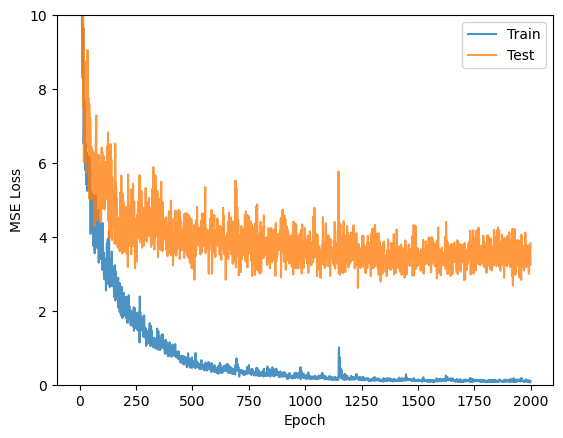

In [7]:
print('The best r2 value was:', best_R2)

fig, ax = plt.subplots()
ax.plot(train_loss_list, label='Train',alpha=0.8)
ax.plot(test_loss_list,label='Test',alpha=0.8)

ax.set_ylim(0,10)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend()

plt.show()

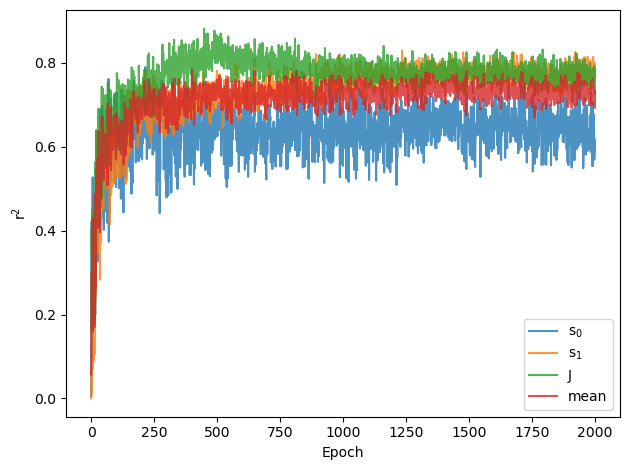

In [8]:
r2_array = np.array(r2_list)
labels = ['s$_0$', 's$_1$', 'J', 'mean']

fig, ax = plt.subplots()
for i in range(r2_array.shape[1]):
    ax.plot(r2_array[:,i],label=labels[i],alpha=0.8)

ax.set_xlabel('Epoch')
ax.set_ylabel('r$^2$')
ax.legend()
ax.tick_params(axis='both')
plt.tight_layout()
plt.show()

## Plot the predicted vs. actuals

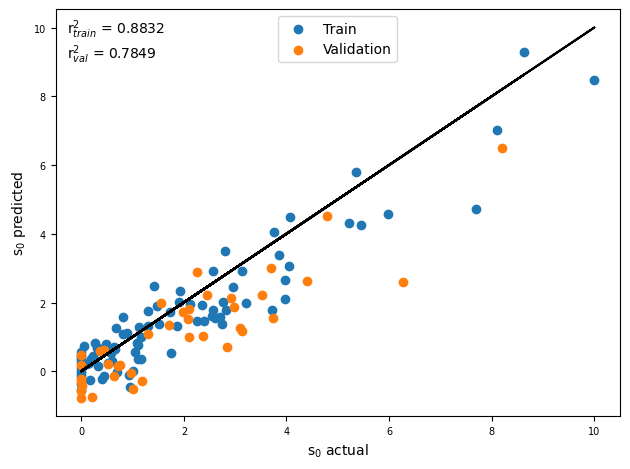

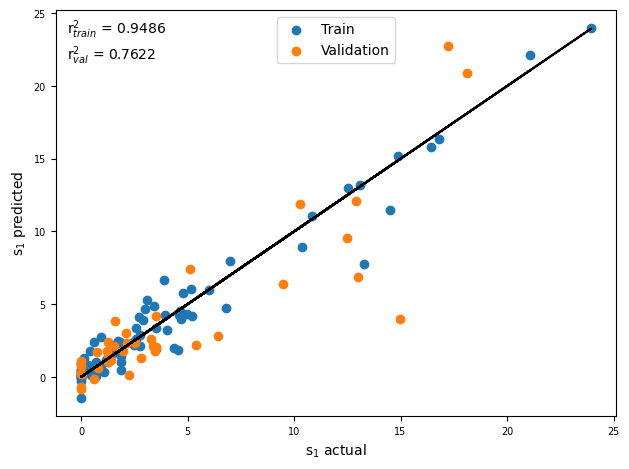

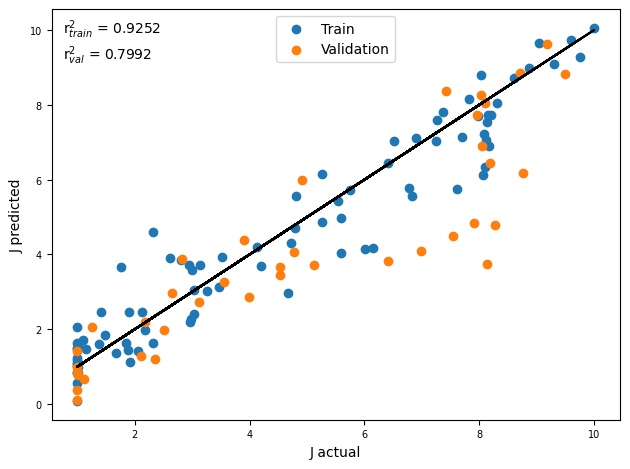

In [9]:
def plot_predictions(train_pred, train_actual, val_pred, val_actual, index, title):
    fig, ax = plt.subplots()
    
    r2_train = pearsonr(train_actual[:,index], train_pred[:,index])[0]**2
    r2_val = pearsonr(val_actual[:,index], val_pred[:,index])[0]**2
    
    ax.scatter(train_actual[:,index],train_pred[:,index],label='Train')
    ax.scatter(val_actual[:,index],val_pred[:,index],label='Validation')
    ax.plot(train_actual[:,index],train_actual[:,index],c='k')
    
    plt.text(0.02, 0.98, 'r$^2_{train}$ = %.4f\nr$^2_{val}$ = %.4f' % (r2_train,r2_val),
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

    ax.legend(loc='upper center')
        
    ax.set_xlabel('{} actual'.format(title))
    ax.set_ylabel('{} predicted'.format(title))
    ax.tick_params(axis='both')
    
    return ax

labels = ['s$_0$', 's$_1$', 'J',]

for i,label in enumerate(labels):
    ax = plot_predictions(best_train_predictions,best_train_actuals,
                     best_val_predictions, best_val_actuals,i,label)
    ax.tick_params(axis='both', labelsize=7)
    plt.tight_layout()